In [1]:
!pip install pickle5

     |████████████████████████████████| 256 kB 19.8 MB/s 


## Carga de librerías

In [15]:
from google.colab import drive
import glob
from skimage.io import imread
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pickle5 as pickle
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import InputLayer,Conv2D,MaxPool2D,Flatten,Dropout,Dense
from tensorflow.keras.regularizers import l1_l2,l1,l2
from tensorflow.keras.losses import CategoricalCrossentropy,BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model


In [53]:
drive.mount('/content/drive')
path="/content/drive/MyDrive/maestria_ciencia_datos/semestre2/aprendizaje_profundo/proyecto/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Carga de imágenes

In [ ]:
# Única ejecución

#image_names_partially_covered = glob.glob(path+'data/partially_covered/*.jpg')
#image_names_not_face = glob.glob(path+'data/not_face/*.jpg')
#image_names_not_covered = glob.glob(path+'data/not_covered/*.jpg')
#image_names_fully_covered = glob.glob(path+'data/fully_covered/*.jpg')

In [ ]:
# Única ejecución

#X_partially_covered =  [imread(img_name) for img_name in image_names_partially_covered]
#X_not_face =  [imread(img_name) for img_name in image_names_not_face]
#X_not_covered =  [imread(img_name) for img_name in image_names_not_covered]
#X_fully_covered =  [imread(img_name) for img_name in image_names_fully_covered]

In [ ]:
# Única ejecución

#pd.to_pickle(X_partially_covered,path+"data/partially_covered.pkl")
#pd.to_pickle(X_not_face,path+"data/not_face.pkl")
#pd.to_pickle(X_not_covered,path+"data/not_covered.pkl")
#pd.to_pickle(X_fully_covered,path+"data/fully_covered.pkl")

In [4]:
infile=open(path+'data/partially_covered.pkl', 'rb')
X_partially_covered=pickle.load(infile)
infile.close()

infile=open(path+'data/not_face.pkl', 'rb')
X_not_face=pickle.load(infile)
infile.close()

infile=open(path+'data/not_covered.pkl', 'rb')
X_not_covered=pickle.load(infile)
infile.close()

infile=open(path+'data/fully_covered.pkl', 'rb')
X_fully_covered=pickle.load(infile)
infile.close()

In [5]:
X_partially_covered=np.array(X_partially_covered)
X_not_face=np.array(X_not_face)
X_not_covered=np.array(X_not_covered)
X_fully_covered=np.array(X_fully_covered)

print(f"Partially covered shape: {X_partially_covered.shape}")
print(f"Not face shape: {X_not_face.shape}")
print(f"Not covered shape: {X_not_covered.shape}")
print(f"Fully covered shape: {X_fully_covered.shape}")


Partially covered shape: (392, 64, 64)
Not face shape: (1114, 64, 64)
Not covered shape: (3664, 64, 64)
Fully covered shape: (1451, 64, 64)


## Feature engineering

In [6]:
X=np.concatenate((X_partially_covered,X_not_face,X_not_covered,X_fully_covered),axis=0)
Y=np.concatenate((np.repeat(1, X_partially_covered.shape[0]),np.repeat(2, X_not_face.shape[0]),
                  np.repeat(3, X_not_covered.shape[0]),np.repeat(4, X_fully_covered.shape[0])),axis=0).reshape(-1,1)
one = OneHotEncoder()
Y=one.fit_transform(Y).toarray()

In [7]:
X2=np.concatenate((X_partially_covered,X_fully_covered,X_not_covered),axis=0)
Y2=np.concatenate((np.repeat(1, X_partially_covered.shape[0]),np.repeat(1, X_fully_covered.shape[0]),
                  np.repeat(0, X_not_covered.shape[0])),axis=0).reshape(-1,1)

In [8]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.1,random_state=0)
X_train,X_val,Y_train,Y_val = train_test_split(X_train,Y_train,test_size=0.15/(1-0.1),random_state=1)

X_train = X_train/255
X_val = X_val/255
X_test = X_test/255

In [9]:
X2_train,X2_test,Y2_train,Y2_test = train_test_split(X2,Y2,test_size=0.1,random_state=0)
X2_train,X2_val,Y2_train,Y2_val = train_test_split(X2_train,Y2_train,test_size=0.15/(1-0.1),random_state=1)

X2_train = X2_train/255
X2_val = X2_val/255
X2_test = X2_test/255

## Modelo

In [ ]:
checkpoints = ModelCheckpoint(
                            path+"data/checkpoint_mejor_modelo_v1.h5",
                            monitor='val_loss', ## que funcion monitorea para crear el checkpoint
                            verbose=10, ## imprima que guardo un checkpoint
                            save_best_only=True, ## solo guarde el mejor model
                            save_weights_only=False, ## Nos guarda la arquitectura y los pesos
                            mode="min", ### Cuando guardar el checkpoint, en este caso, cada nuevo minimo en la funcion de val_loss
                            save_freq='epoch') ### Cada cuando guarda el checkpoint

checkpoints2 = ModelCheckpoint(
                            path+"data/checkpoint2_mejor_modelo_v1.h5",
                            monitor='val_loss', ## que funcion monitorea para crear el checkpoint
                            verbose=10, ## imprima que guardo un checkpoint
                            save_best_only=True, ## solo guarde el mejor model
                            save_weights_only=False, ## Nos guarda la arquitectura y los pesos
                            mode="min", ### Cuando guardar el checkpoint, en este caso, cada nuevo minimo en la funcion de val_loss
                            save_freq='epoch') ### Cada cuando guarda el checkpoint

In [ ]:
model = Sequential()
model.add(InputLayer(input_shape=(64,64,1))) ## las dimensiones de la imagen
model.add(Conv2D(filters= 16 , kernel_size=(2,2),strides=(1,1), padding="same", activation = "relu" ))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2),padding='valid')) 
model.add(Dropout(0.2))
model.add(Conv2D(filters= 32 , kernel_size=(3,3),strides=(1,1), padding="same", activation = "LeakyReLU" ))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2),padding='valid'))  
model.add(Conv2D(filters= 64 , kernel_size=(2,2),strides=(1,1), padding="same", activation = "relu" ))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2),padding='valid')) 
model.add(Flatten()) ## convetimos un tensor de cualesquiera dimensiones a un vector 
model.add(Dropout(0.2))
model.add(Dense(units=256, activation ="relu"))
model.add(Dense(units=128, activation ="LeakyReLU"))
model.add(Dense(units=64, activation ="relu", kernel_regularizer= l1_l2(0.01,0.01)))
model.add(Dense(4, activation="softmax"))

model.compile(loss=CategoricalCrossentropy(), optimizer=Adam(0.0001,), metrics= ["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 16)        80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        8

In [ ]:
model2 = Sequential()
model2.add(InputLayer(input_shape=(64,64,1))) ## las dimensiones de la imagen
model2.add(Conv2D(filters= 16 , kernel_size=(2,2),strides=(1,1), padding="same", activation = "relu" ))
model2.add(MaxPool2D(pool_size=(2,2),strides=(2,2),padding='valid')) 
model2.add(Dropout(0.2))
model2.add(Conv2D(filters= 32 , kernel_size=(3,3),strides=(1,1), padding="same", activation = "LeakyReLU" ))
model2.add(MaxPool2D(pool_size=(2,2),strides=(2,2),padding='valid'))  
model2.add(Conv2D(filters= 64 , kernel_size=(2,2),strides=(1,1), padding="same", activation = "relu" ))
model2.add(MaxPool2D(pool_size=(2,2),strides=(2,2),padding='valid')) 
model2.add(Flatten()) ## convetimos un tensor de cualesquiera dimensiones a un vector 
model2.add(Dropout(0.2))
model2.add(Dense(units=256, activation ="relu"))
model2.add(Dense(units=128, activation ="LeakyReLU"))
model2.add(Dense(units=64, activation ="relu", kernel_regularizer= l1_l2(0.01,0.01)))
model2.add(Dense(1, activation="sigmoid"))

model2.compile(loss=BinaryCrossentropy(), optimizer=Adam(0.0001,), metrics= ["accuracy","AUC"])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 64, 64, 16)        80        
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 32, 32, 16)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 64)       

In [ ]:
history = model.fit(X_train,Y_train, epochs= 100, batch_size =64, validation_data=(X_val,Y_val),callbacks=[checkpoints])

Epoch 1/100
78/78 [==============================] - ETA: 0s - loss: 8.7956 - accuracy: 0.5442
Epoch 1: val_loss improved from inf to 8.32747, saving model to /content/drive/MyDrive/maestria_ciencia_datos/semestre2/aprendizaje_profundo/proyecto/data/checkpoint_mejor_modelo_v1.h5
78/78 [==============================] - 13s 25ms/step - loss: 8.7956 - accuracy: 0.5442 - val_loss: 8.3275 - val_accuracy: 0.5549
Epoch 2/100
73/78 [===========================>..] - ETA: 0s - loss: 7.9191 - accuracy: 0.6192
Epoch 2: val_loss improved from 8.32747 to 7.48630, saving model to /content/drive/MyDrive/maestria_ciencia_datos/semestre2/aprendizaje_profundo/proyecto/data/checkpoint_mejor_modelo_v1.h5
78/78 [==============================] - 1s 15ms/step - loss: 7.8971 - accuracy: 0.6197 - val_loss: 7.4863 - val_accuracy: 0.7019
Epoch 3/100
76/78 [============================>.] - ETA: 0s - loss: 7.1212 - accuracy: 0.7050
Epoch 3: val_loss improved from 7.48630 to 6.75107, saving model to /content/dri

In [ ]:
history2 = model2.fit(X2_train,Y2_train, epochs= 100, batch_size =64, validation_data=(X2_val,Y2_val),callbacks=[checkpoints2])

Epoch 1/100
65/65 [==============================] - ETA: 0s - loss: 8.4118 - accuracy: 0.6956 - auc: 0.7068
Epoch 1: val_loss improved from inf to 8.01217, saving model to /content/drive/MyDrive/maestria_ciencia_datos/semestre2/aprendizaje_profundo/proyecto/data/checkpoint2_mejor_modelo_v1.h5
65/65 [==============================] - 4s 30ms/step - loss: 8.4118 - accuracy: 0.6956 - auc: 0.7068 - val_loss: 8.0122 - val_accuracy: 0.7845 - val_auc: 0.8326
Epoch 2/100
60/65 [==========================>...] - ETA: 0s - loss: 7.6847 - accuracy: 0.8031 - auc: 0.8687
Epoch 2: val_loss improved from 8.01217 to 7.34395, saving model to /content/drive/MyDrive/maestria_ciencia_datos/semestre2/aprendizaje_profundo/proyecto/data/checkpoint2_mejor_modelo_v1.h5
65/65 [==============================] - 1s 10ms/step - loss: 7.6657 - accuracy: 0.8017 - auc: 0.8674 - val_loss: 7.3439 - val_accuracy: 0.8414 - val_auc: 0.9056
Epoch 3/100
60/65 [==========================>...] - ETA: 0s - loss: 7.0680 - accu

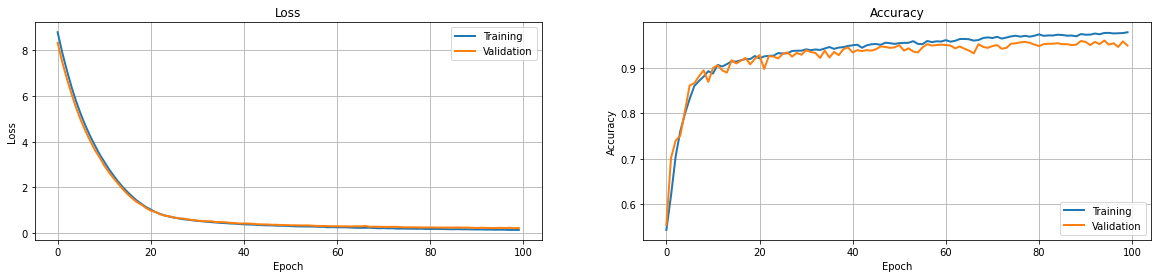

In [ ]:
# Plot loss
plt.figure(figsize=(20, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(model.history.history['loss'], label='Training', linewidth=2)
plt.plot(model.history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(model.history.history['accuracy'], label='Training', linewidth=2)
plt.plot(model.history.history['val_accuracy'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.show()

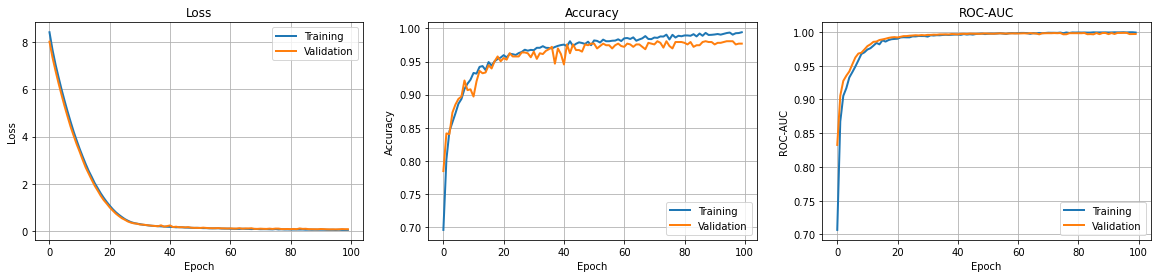

In [ ]:
# Plot loss
plt.figure(figsize=(20, 4))

plt.subplot(1, 3, 1)
plt.title('Loss')
plt.plot(model2.history.history['loss'], label='Training', linewidth=2)
plt.plot(model2.history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 3, 2)
plt.title('Accuracy')
plt.plot(model2.history.history['accuracy'], label='Training', linewidth=2)
plt.plot(model2.history.history['val_accuracy'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.subplot(1, 3, 3)
plt.title('ROC-AUC')
plt.plot(model2.history.history['auc'], label='Training', linewidth=2)
plt.plot(model2.history.history['val_auc'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('ROC-AUC')
plt.grid(True)

plt.show()

## Resultados

In [10]:
best_model = load_model(path+"data/checkpoint_mejor_modelo_v1.h5")
best_model2 = load_model(path+"data/checkpoint2_mejor_modelo_v1.h5")

In [11]:
train_loss = best_model.evaluate(x=X_train, y=Y_train)
train_acc = accuracy_score(y_true=np.argmax(Y_train, axis=1),y_pred=np.argmax(best_model.predict(x=X_train),axis=1))
#train_roc = roc_auc_score(y_true=np.argmax(Y_train, axis=1),y_score=np.argmax(best_model.predict(x=X_train),axis=1))
#train_pre = precision_score(y_true=np.argmax(Y_train, axis=1),y_pred=np.argmax(best_model.predict(x=X_train),axis=1))
#train_rec = recall_score(y_true=np.argmax(Y_train, axis=1),y_pred=np.argmax(best_model.predict(x=X_train),axis=1))

test_loss = best_model.evaluate(x=X_test, y=Y_test)
test_acc = accuracy_score(y_true=np.argmax(Y_test, axis=1),y_pred=np.argmax(best_model.predict(x=X_test),axis=1))
#test_roc = roc_auc_score(y_true=np.argmax(Y_test, axis=1),y_score=np.argmax(best_model.predict(x=X_test),axis=1))
#test_pre = precision_score(y_true=np.argmax(Y_test, axis=1),y_pred=np.argmax(best_model.predict(x=X_test),axis=1))
#test_rec = recall_score(y_true=np.argmax(Y_test, axis=1),y_pred=np.argmax(best_model.predict(x=X_test),axis=1))

print("Train:")
print(f"Loss: {train_loss}")
print(f"Accuracy: {train_acc}")
#print(f"Roc-Auc: {train_roc}")
#print(f"Precision: {train_pre}")
#print(f"Recall: {train_rec}")
print("\n")
print("Test:")
print(f"Loss: {test_loss}")
print(f"Accuracy: {test_acc}")
#print(f"Roc-Auc: {test_roc}")
#print(f"Precision: {test_pre}")
#print(f"Recall: {test_rec}")

21/21 [==============================] - 0s 6ms/step - loss: 0.1938 - accuracy: 0.9653
Train:
Loss: [0.129351407289505, 0.9852970838546753]
Accuracy: 0.9852970795568983


Test:
Loss: [0.193765327334404, 0.965309202671051]
Accuracy: 0.9653092006033183


In [12]:
train_loss = best_model2.evaluate(x=X2_train, y=Y2_train)

train_acc = accuracy_score(y_true=Y2_train,y_pred=np.array([1 if x>=0.5 else 0 for x in best_model2.predict(x=X2_train)]))
train_roc = roc_auc_score(y_true=Y2_train,y_score=np.array([1 if x>=0.5 else 0 for x in best_model2.predict(x=X2_train)]))
train_pre = precision_score(y_true=Y2_train,y_pred=np.array([1 if x>=0.5 else 0 for x in best_model2.predict(x=X2_train)]))
train_rec = recall_score(y_true=Y2_train,y_pred=np.array([1 if x>=0.5 else 0 for x in best_model2.predict(x=X2_train)]))

test_loss = best_model2.evaluate(x=X2_test, y=Y2_test)
test_acc = accuracy_score(y_true=Y2_test,y_pred=np.array([1 if x>=0.5 else 0 for x in best_model2.predict(x=X2_test)]))
test_roc = roc_auc_score(y_true=Y2_test,y_score=np.array([1 if x>=0.5 else 0 for x in best_model2.predict(x=X2_test)]))
test_pre = precision_score(y_true=Y2_test,y_pred=np.array([1 if x>=0.5 else 0 for x in best_model2.predict(x=X2_test)]))
test_rec = recall_score(y_true=Y2_test,y_pred=np.array([1 if x>=0.5 else 0 for x in best_model2.predict(x=X2_test)]))

print("Train:")
print(f"Loss: {train_loss}")
print(f"Accuracy: {train_acc}")
print(f"Roc-Auc: {train_roc}")
print(f"Precision: {train_pre}")
print(f"Recall: {train_rec}")
print("\n")
print("Test:")
print(f"Loss: {test_loss}")
print(f"Accuracy: {test_acc}")
print(f"Roc-Auc: {test_roc}")
print(f"Precision: {test_pre}")
print(f"Recall: {test_rec}")

18/18 [==============================] - 0s 6ms/step - loss: 0.0968 - accuracy: 0.9764 - auc: 0.9970
Train:
Loss: [0.042746495455503464, 0.9978207945823669, 0.9997523427009583]
Accuracy: 0.997820823244552
Roc-Auc: 0.9980038167859151
Precision: 0.9950319375443577
Recall: 0.9985754985754985


Test:
Loss: [0.09679210931062698, 0.9764065146446228, 0.9970435500144958]
Accuracy: 0.9764065335753176
Roc-Auc: 0.9683216365536806
Precision: 0.9827586206896551
Recall: 0.9447513812154696


In [13]:
Y_test_hat = best_model.predict(x=X_test)

Y_test_hat_cat = np.argmax(Y_test_hat, axis=1)
Y_test_cat = np.argmax(Y_test, axis=1)
cm=confusion_matrix(y_true=Y_test_cat, y_pred=Y_test_hat_cat)

print(cm)
print("\n")
print(np.round(np.transpose(np.transpose(cm)/cm.sum(axis=1)),3)*100)

[[ 37   0   0   0]
 [  0  86   5   1]
 [  0   2 368   1]
 [  4   3   7 149]]


[[100.    0.    0.    0. ]
 [  0.   93.5   5.4   1.1]
 [  0.    0.5  99.2   0.3]
 [  2.5   1.8   4.3  91.4]]


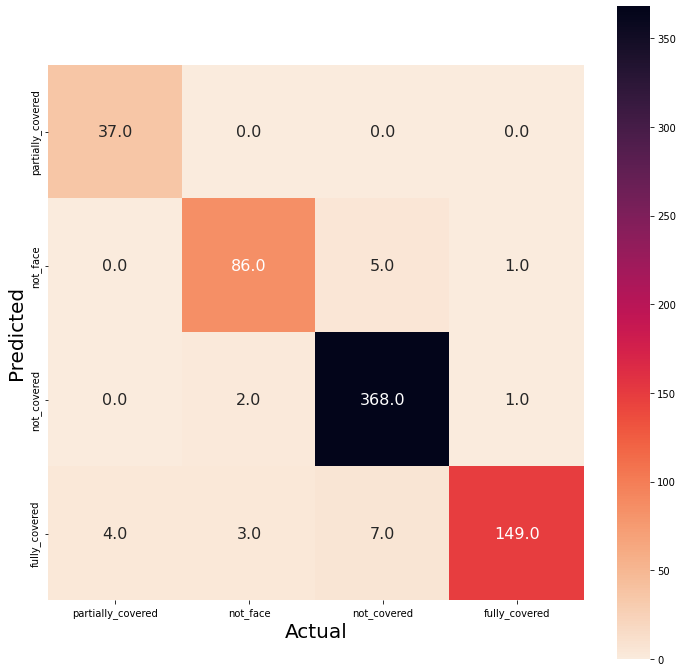

In [39]:
y_label=["partially_covered","not_face","not_covered","fully_covered"]
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap="rocket_r", fmt=".01f",annot_kws={'size':16}, annot=True, square=True, xticklabels=y_label, yticklabels=y_label)
ax.set_ylabel('Predicted', fontsize=20)
ax.set_xlabel('Actual', fontsize=20)
plt.show()

In [40]:
Y2_test_hat = best_model2.predict(x=X2_test)

Y2_test_hat_cat = np.array([1 if x>=0.5 else 0 for x in Y2_test_hat])
Y2_test_cat = Y2_test
cm2=confusion_matrix(y_true=Y2_test_cat, y_pred=Y2_test_hat_cat)

print(cm2)
print("\n")
print(np.round(np.transpose(np.transpose(cm2)/cm2.sum(axis=1)),3)*100)

[[367   3]
 [ 10 171]]


[[99.2  0.8]
 [ 5.5 94.5]]


In [41]:
Y_test_hat = best_model.predict(x=X_test)
Y_test_cat = np.argmax(Y_test, axis=1)
Y_test_hat_cat = np.argmax(Y_test_hat, axis=1)

def cambio(x):
  if x==0:
    y="partially_covered"
  else:
    if x==1:
      y="not_face"
    else:
      if x==2:
        y="not_covered"
      else:
        if x==3:
          y="fully_covered"
        else:
          y=None
  return y

In [42]:
Y2_test_hat = best_model2.predict(x=X2_test)
Y2_test_cat = Y2_test
Y2_test_hat_cat = np.array([1 if x>=0.5 else 0 for x in Y2_test_hat])

def cambio2(x):
  if x==0:
    y="not_covered"
  else:
    if x==1:
      y="covered"
    else:
      y=None
  return y

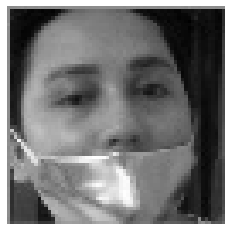

Real: partially_covered
Predict: partially_covered


In [43]:
i=639
plt.imshow(X_test[i],cmap='gray')
plt.axis('off')
plt.show()
print(f"Real: {cambio(Y_test_cat[i])}")
print(f"Predict: {cambio(Y_test_hat_cat[i])}")

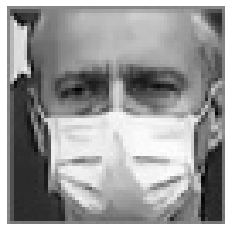

Real: covered
Predict: covered


In [44]:
i=502
plt.imshow(X2_test[i],cmap='gray')
plt.axis('off')
plt.show()
print(f"Real: {cambio2(Y2_test_cat[i])}")
print(f"Predict: {cambio2(Y2_test_hat_cat[i])}")

## Layers CNN

In [45]:
model1 = Model(inputs=best_model.inputs, outputs=best_model.layers[6].output)
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 16)        80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                         

Shape: (663, 8, 8, 64)
Shape of responses for one instance: (8, 8, 64)


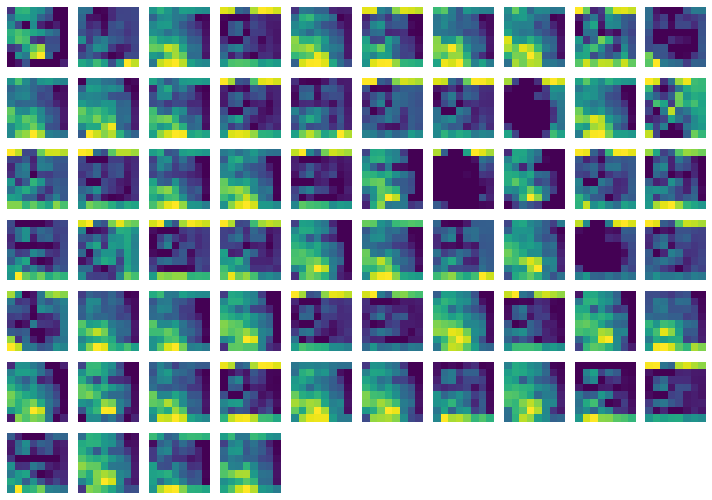

In [46]:
i=639

# Predict 
feat_map = model1.predict(X_test)
print(f"Shape: {feat_map.shape}")

# Get feature maps (kernel responses) for 1st instance in the batch
a_sample = feat_map[i]
print(f"Shape of responses for one instance: {a_sample.shape}")

# Show a few feature maps (kernel responses)
plt.figure(figsize=(10, 10))
for ind in range(64):
  img = a_sample[:,:, ind].copy()
  img -= img.min()
  img /= img.max()
  plt.subplot(10, 10, ind+1)
  plt.imshow(img, cmap='viridis')
  plt.axis('off')
plt.tight_layout()
plt.show()

In [47]:
model2 = Model(inputs=best_model2.inputs, outputs=best_model2.layers[6].output)
model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 16)        80        
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 32, 32, 16)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                       

Shape: (551, 8, 8, 64)
Shape of responses for one instance: (8, 8, 64)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:993: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)


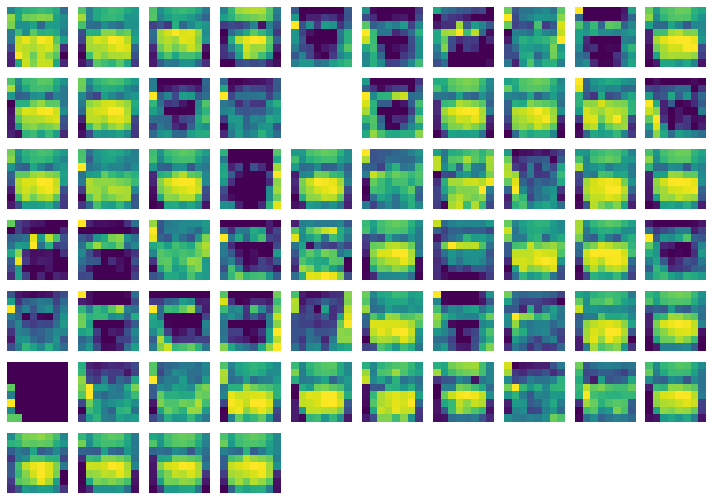

In [48]:
i=502

# Predict 
feat_map = model2.predict(X2_test)
print(f"Shape: {feat_map.shape}")

# Get feature maps (kernel responses) for 1st instance in the batch
a_sample = feat_map[i]
print(f"Shape of responses for one instance: {a_sample.shape}")

# Show a few feature maps (kernel responses)
plt.figure(figsize=(10, 10))
for ind in range(64):
  img = a_sample[:,:, ind].copy()
  img -= img.min()
  img /= img.max()
  plt.subplot(10, 10, ind+1)
  plt.imshow(img, cmap='viridis')
  plt.axis('off')
plt.tight_layout()
plt.show()

## Imágenes ejemplos

In [87]:
infile=open(path+'data/unseen.pkl', 'rb')
X_unseen=pickle.load(infile)
infile.close()
X_unseen=np.array(X_unseen)
#X_unseen= X_unseen/255

infile=open(path+'data/equipo.pkl', 'rb')
X_equipo=pickle.load(infile)
infile.close()
X_equipo=np.array(X_equipo)
#X_equipo= X_equipo/255

infile=open(path+'data/caras.pkl', 'rb')
X_caras=pickle.load(infile)
infile.close()
X_caras=np.array(X_caras)
#X_caras= X_caras/255

Z=np.concatenate((X_unseen,X_equipo,X_caras),axis=0).reshape(31,64,64)
Z.shape

(31, 64, 64)

In [90]:
Z_test_hat = best_model.predict(x=Z)
Z_test_hat_cat = np.argmax(Z_test_hat, axis=1)

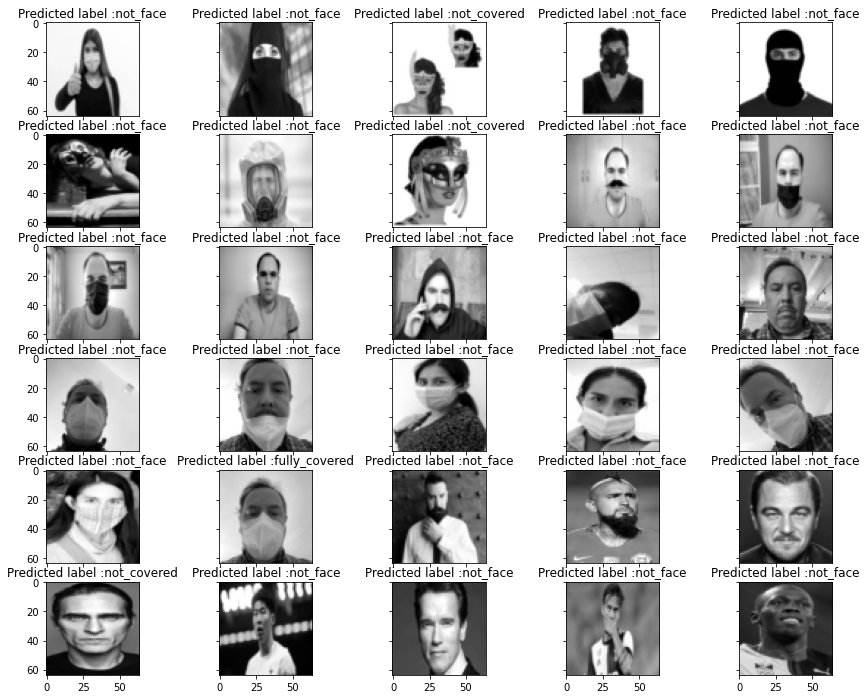

In [100]:
nrows = 6
ncols = 5
fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(15, 12))
n = 0
for row in range(nrows):
    for col in range(ncols):
            ax[row,col].imshow(Z[n], cmap='gray')
            ax[row,col].set_title("Predicted label :{}".format(cambio(Z_test_hat_cat[n])))
            n += 1
plt.show()

In [112]:
model1 = Model(inputs=best_model.inputs, outputs=best_model.layers[3].output)
model1.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 16)        80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
Total params: 4,720
Trainable params: 4,720
Non-trainable params: 0
_________________________________________________________

Shape: (31, 32, 32, 32)
Shape of responses for one instance: (32, 32, 32)


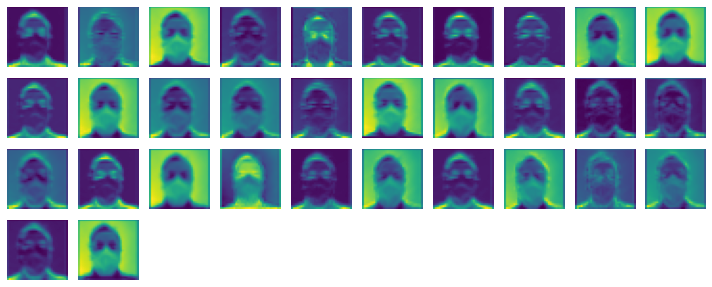

In [119]:
# Ejemplo exitoso
i=21

# Predict 
feat_map = model1.predict(Z)
print(f"Shape: {feat_map.shape}")

# Get feature maps (kernel responses) for 1st instance in the batch
a_sample = feat_map[i]
print(f"Shape of responses for one instance: {a_sample.shape}")

# Show a few feature maps (kernel responses)
plt.figure(figsize=(10, 10))
for ind in range(32):
  img = a_sample[:,:, ind].copy()
  img -= img.min()
  img /= img.max()
  plt.subplot(10, 10, ind+1)
  plt.imshow(img, cmap='viridis')
  plt.axis('off')
plt.tight_layout()
plt.show()

Shape: (31, 32, 32, 32)
Shape of responses for one instance: (32, 32, 32)


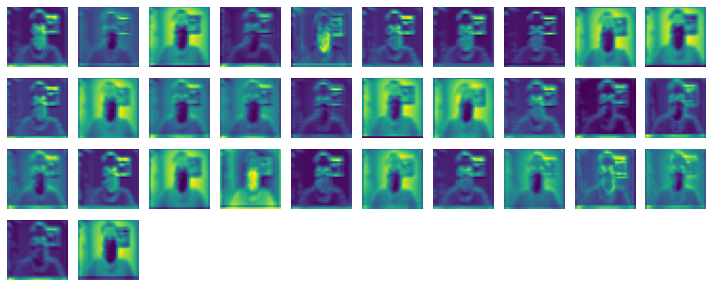

In [122]:
# Ejemplo fracaso
i=10

# Predict 
feat_map = model1.predict(Z)
print(f"Shape: {feat_map.shape}")

# Get feature maps (kernel responses) for 1st instance in the batch
a_sample = feat_map[i]
print(f"Shape of responses for one instance: {a_sample.shape}")

# Show a few feature maps (kernel responses)
plt.figure(figsize=(10, 10))
for ind in range(32):
  img = a_sample[:,:, ind].copy()
  img -= img.min()
  img /= img.max()
  plt.subplot(10, 10, ind+1)
  plt.imshow(img, cmap='viridis')
  plt.axis('off')
plt.tight_layout()
plt.show()